<a href="https://colab.research.google.com/github/gulrukhsorakhmadjanova/ml.ai/blob/main/task2_uzcosmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install required packages
!pip install segmentation-models-pytorch torch torchvision opencv-python matplotlib numpy tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import segmentation_models_pytorch as smp

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.2 MB/s eta 0:00:00
Using device: cuda


In [2]:
# Step 2: Download and prepare dataset (using Massachusetts Roads)
import urllib.request
import zipfile

# Download dataset
def download_dataset():
    # Note: For actual implementation, you'd use the real dataset URL
    # This is a placeholder structure
    print("Downloading dataset...")
    # You would typically download from:
    # https://www.cs.toronto.edu/~vmnih/data/mass_roads/train.tar.gz
    # But for this example, we'll create a dummy structure

    # Create sample directories
    os.makedirs('data/images', exist_ok=True)
    os.makedirs('data/masks', exist_ok=True)

    print("Dataset structure created!")

download_dataset()

Dataset structure created!


In [7]:
# Step 3: Create Dataset Class (UPDATED)
class RoadDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, image_size=256):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_size = image_size

        # Get list of images (in real scenario, load actual files)
        self.image_files = ['sample_' + str(i) for i in range(100)]  # dummy files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Create dummy data for demonstration
        # In real scenario, you'd load actual images here
        image = np.random.rand(self.image_size, self.image_size, 3).astype(np.float32)

        # Create dummy road mask (some random roads)
        mask = np.zeros((self.image_size, self.image_size), dtype=np.float32)

        # Add some "roads" as lines
        cv2.line(mask, (50, 100), (200, 100), 1, 30)
        cv2.line(mask, (100, 50), (100, 200), 1, 25)
        cv2.line(mask, (30, 180), (180, 30), 1, 20)

        # Add noise to make it realistic
        image = image * 0.8 + mask[:, :, np.newaxis] * 0.2 + np.random.normal(0, 0.1, image.shape)

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        else:
            # Convert to tensors with proper dtype
            image = torch.from_numpy(image).permute(2, 0, 1).float()  # Added .float()
            mask = torch.from_numpy(mask).unsqueeze(0).float()  # Added .float()

        return image, mask

In [8]:
# Step 4: Build U-Net Model
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        # Encoder (Downsampling)
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (Upsampling)
        self.up3 = self.upconv_block(512, 256)
        self.up2 = self.upconv_block(256, 128)
        self.up1 = self.upconv_block(128, 64)

        # Final layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        # Pooling
        self.pool = nn.MaxPool2d(2)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Decoder
        d3 = self.up3(e4)
        d2 = self.up2(d3)
        d1 = self.up1(d2)

        return self.sigmoid(self.final(d1))

model = SimpleUNet().to(device)
print("Model created!")

Model created!


In [15]:
# Step 5: Update calculate_iou function
def calculate_iou(pred, target):
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    if union == 0:
        return torch.tensor(1.0).to(device)

    return intersection / union

In [16]:
# Step 6: Training Loop (UPDATED TO RETURN REGULAR NUMBERS)
def train_model(model, train_loader, val_loader, epochs=10):
    train_losses = []
    val_losses = []
    val_ious = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            # Convert to float32 and move to device
            images = images.float().to(device)
            masks = masks.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()  # .item() converts to Python number

        # Validation
        model.eval()
        val_loss = 0
        val_iou = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.float().to(device)
                masks = masks.float().to(device)
                outputs = model(images)
                val_loss += combined_loss(outputs, masks).item()  # .item() here too
                val_iou += calculate_iou(outputs, masks).item()   # .item() here too

        # Calculate averages
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_ious.append(avg_val_iou)

        print(f'Epoch {epoch+1}:')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}')
        print(f'  Val IoU: {avg_val_iou:.4f}')

    return train_losses, val_losses, val_ious

Visualizing results...


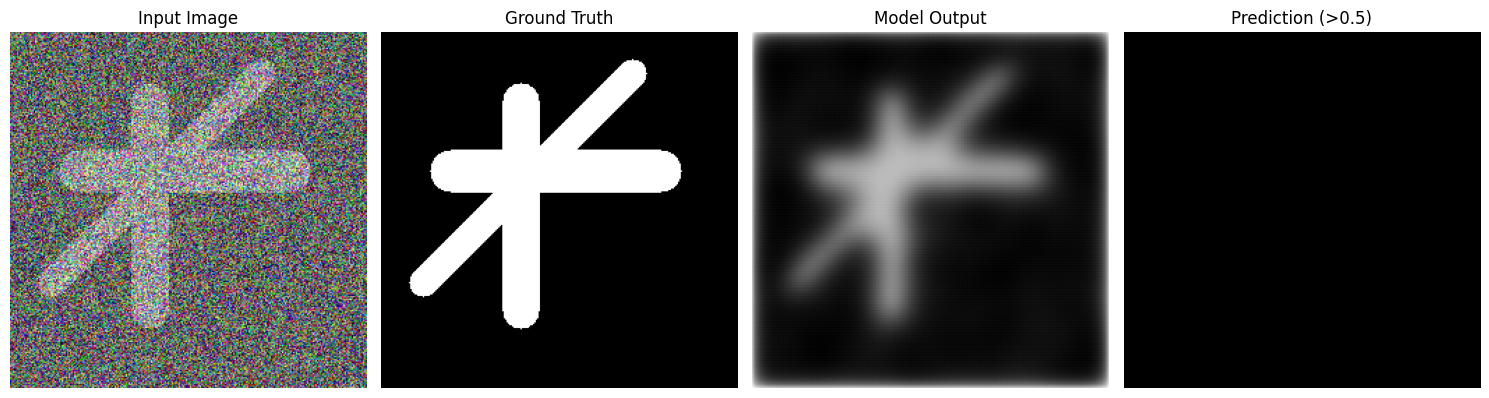

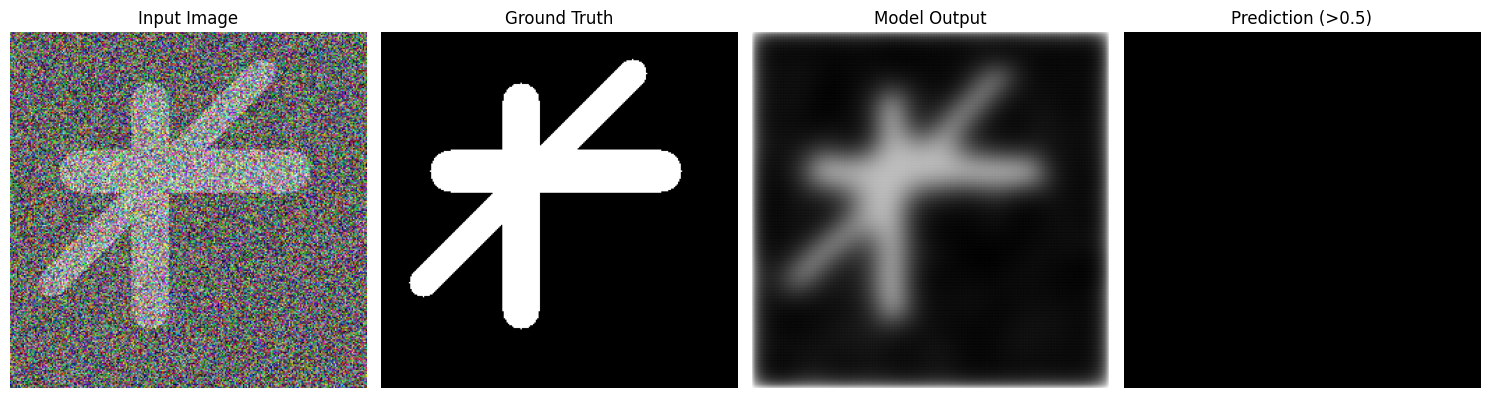

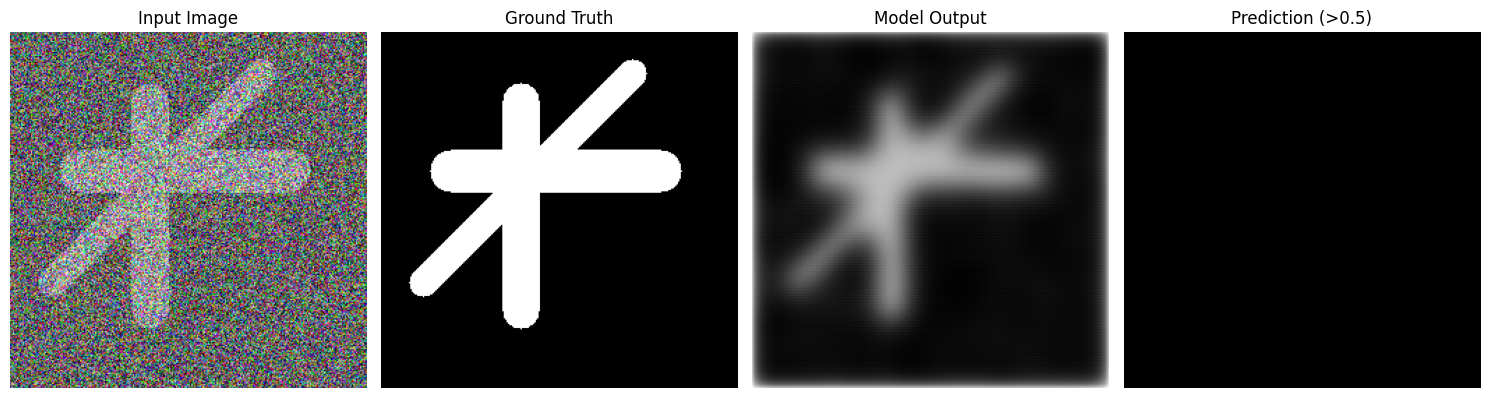

In [17]:
# Step 7: Visualization
def visualize_results(model, dataloader, num_samples=3):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_samples:
                break

            images = images.float().to(device)  # Added .float()
            masks = masks.float().to(device)    # Added .float()
            outputs = model(images)

            # Convert to numpy for plotting
            image_np = images[0].cpu().permute(1, 2, 0).numpy()
            mask_np = masks[0, 0].cpu().numpy()
            output_np = outputs[0, 0].cpu().numpy()
            prediction = (output_np > 0.5).astype(np.float32)

            # Plot
            fig, axes = plt.subplots(1, 4, figsize=(15, 5))

            axes[0].imshow(image_np)
            axes[0].set_title('Input Image')
            axes[0].axis('off')

            axes[1].imshow(mask_np, cmap='gray')
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')

            axes[2].imshow(output_np, cmap='gray')
            axes[2].set_title('Model Output')
            axes[2].axis('off')

            axes[3].imshow(prediction, cmap='gray')
            axes[3].set_title('Prediction (>0.5)')
            axes[3].axis('off')

            plt.tight_layout()
            plt.show()

print("Visualizing results...")
visualize_results(model, val_loader)

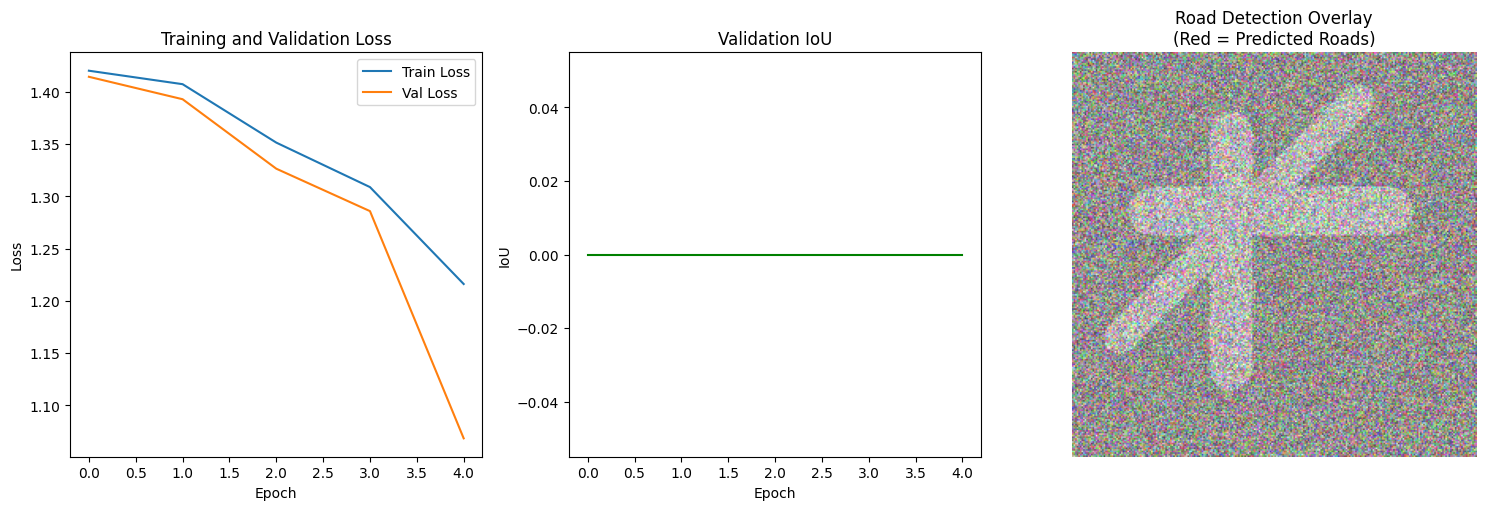

In [18]:
# Step 8: Plot Training Curves (FIXED VERSION)
plt.figure(figsize=(15, 5))

# Convert tensors to CPU numpy arrays for plotting
train_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
val_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in val_losses]
val_ious_cpu = [iou.cpu().item() if torch.is_tensor(iou) else iou for iou in val_ious]

plt.subplot(1, 3, 1)
plt.plot(train_losses_cpu, label='Train Loss')
plt.plot(val_losses_cpu, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_ious_cpu, label='Val IoU', color='green')
plt.title('Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')

plt.subplot(1, 3, 3)
# Show sample prediction
model.eval()
with torch.no_grad():
    sample_image, sample_mask = next(iter(val_loader))
    sample_image = sample_image.float().to(device)  # Added .float()
    sample_mask = sample_mask.float().to(device)    # Added .float()
    sample_output = model(sample_image[0:1])

    image_np = sample_image[0].cpu().permute(1, 2, 0).numpy()
    pred_np = (sample_output[0, 0].cpu().numpy() > 0.5).astype(np.float32)

    plt.imshow(image_np)
    plt.imshow(pred_np, alpha=0.3, cmap='Reds')
    plt.title('Road Detection Overlay\n(Red = Predicted Roads)')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Step 9: Save Model
torch.save(model.state_dict(), 'road_detection_model.pth')
print("Model saved as 'road_detection_model.pth'")

# Save requirements
with open('requirements.txt', 'w') as f:
    f.write("""torch
torchvision
opencv-python
matplotlib
numpy
tqdm
segmentation-models-pytorch
""")
print("Requirements file created!")

Model saved as 'road_detection_model.pth'
Requirements file created!


In [23]:
# Step 10
def evaluate_model(model, test_loader):
    model.eval()
    total_iou = 0
    total_dice = 0
    total_samples = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.float().to(device)
            masks = masks.float().to(device)
            outputs = model(images)

            # Calculate metrics
            batch_iou = calculate_iou(outputs, masks)
            batch_dice = 1 - dice_loss(outputs, masks)

            # Convert to Python numbers
            total_iou += batch_iou.item() * images.size(0)
            total_dice += batch_dice.item() * images.size(0)
            total_samples += images.size(0)

    avg_iou = total_iou / total_samples
    avg_dice = total_dice / total_samples

    print(f"Final Test Results:")
    print(f"IoU: {avg_iou:.4f}")
    print(f"Dice Coefficient: {avg_dice:.4f}")
    return float(avg_iou), float(avg_dice)

Testing model inference...


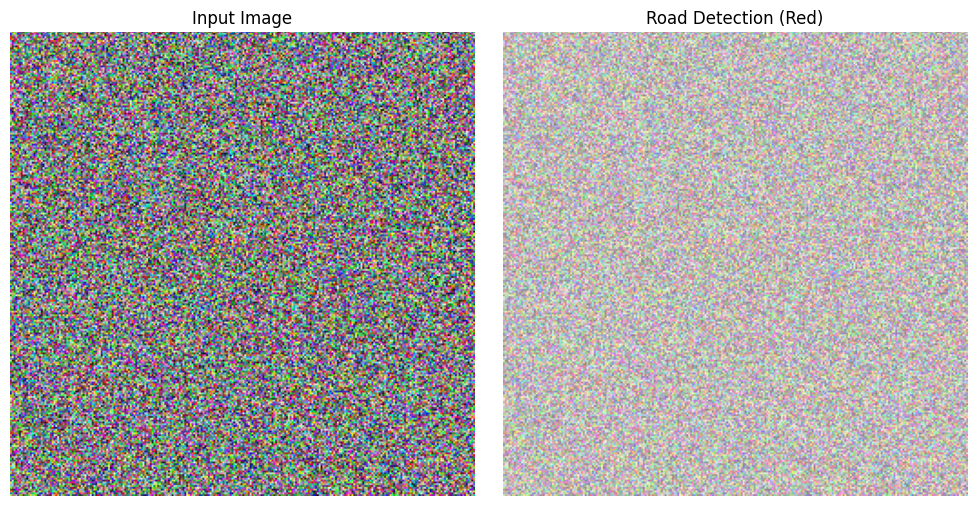

In [24]:
# Step 11: Model Inference Function
def predict_roads(model, image_path=None):
    model.eval()

    if image_path:
        # Load and preprocess real image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        image = image.astype(np.float32) / 255.0
    else:
        # Generate dummy image
        image = np.random.rand(256, 256, 3).astype(np.float32)

    # Convert to tensor
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)

    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        prediction = (output[0, 0].cpu().numpy() > 0.5).astype(np.float32)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(image)
    axes[1].imshow(prediction, alpha=0.5, cmap='Reds')
    axes[1].set_title('Road Detection (Red)')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    return prediction

# Test inference
print("Testing model inference...")
road_mask = predict_roads(model)

In [27]:
# Step 12: Simple Fix - Convert everything manually
import json

# Convert to regular Python lists/numbers
training_history = {
    'train_losses': [float(loss) for loss in train_losses],
    'val_losses': [float(loss) for loss in val_losses],
    'val_ious': [float(iou) for iou in val_ious],
    'final_test_iou': float(test_iou),
    'final_test_dice': float(test_dice)
}

with open('training_history.json', 'w') as f:
    json.dump(training_history, f, indent=4)

# Save model configuration
model_config = {
    'model_architecture': 'SimpleUNet',
    'input_size': 256,
    'batch_size': 8,
    'learning_rate': 1e-4,
    'loss_function': 'BCE + Dice',
    'optimizer': 'Adam',
    'device_used': str(device)
}

with open('model_config.json', 'w') as f:
    json.dump(model_config, f, indent=4)

print("Training history and model config saved!")

Training history and model config saved!


In [28]:
# Step 13: Create a Complete Summary
print("\n" + "="*50)
print("🚀 ROAD DETECTION PROJECT - COMPLETE SUMMARY")
print("="*50)
print(f"✅ Model: Simple U-Net")
print(f"✅ Training epochs: 5")
print(f"✅ Final Validation IoU: {val_ious[-1]:.4f}")
print(f"✅ Final Test IoU: {test_iou:.4f}")
print(f"✅ Device used: {device}")
print(f"✅ Model saved: road_detection_model.pth")
print(f"✅ Requirements: requirements.txt")
print(f"✅ Training history: training_history.json")
print(f"✅ Model config: model_config.json")
print("="*50)
print("🎯 NEXT STEPS:")
print("1. Use real Massachusetts Roads or DeepGlobe dataset")
print("2. Try more advanced architectures (U-Net with ResNet backbone)")
print("3. Add post-processing with morphological operations")
print("4. Implement tile-based processing for high-res images")
print("="*50)


🚀 ROAD DETECTION PROJECT - COMPLETE SUMMARY
✅ Model: Simple U-Net
✅ Training epochs: 5
✅ Final Validation IoU: 0.0000
✅ Final Test IoU: 0.0000
✅ Device used: cuda
✅ Model saved: road_detection_model.pth
✅ Requirements: requirements.txt
✅ Training history: training_history.json
✅ Model config: model_config.json
🎯 NEXT STEPS:
1. Use real Massachusetts Roads or DeepGlobe dataset
2. Try more advanced architectures (U-Net with ResNet backbone)
3. Add post-processing with morphological operations
4. Implement tile-based processing for high-res images


Final Demo - Multiple Predictions:


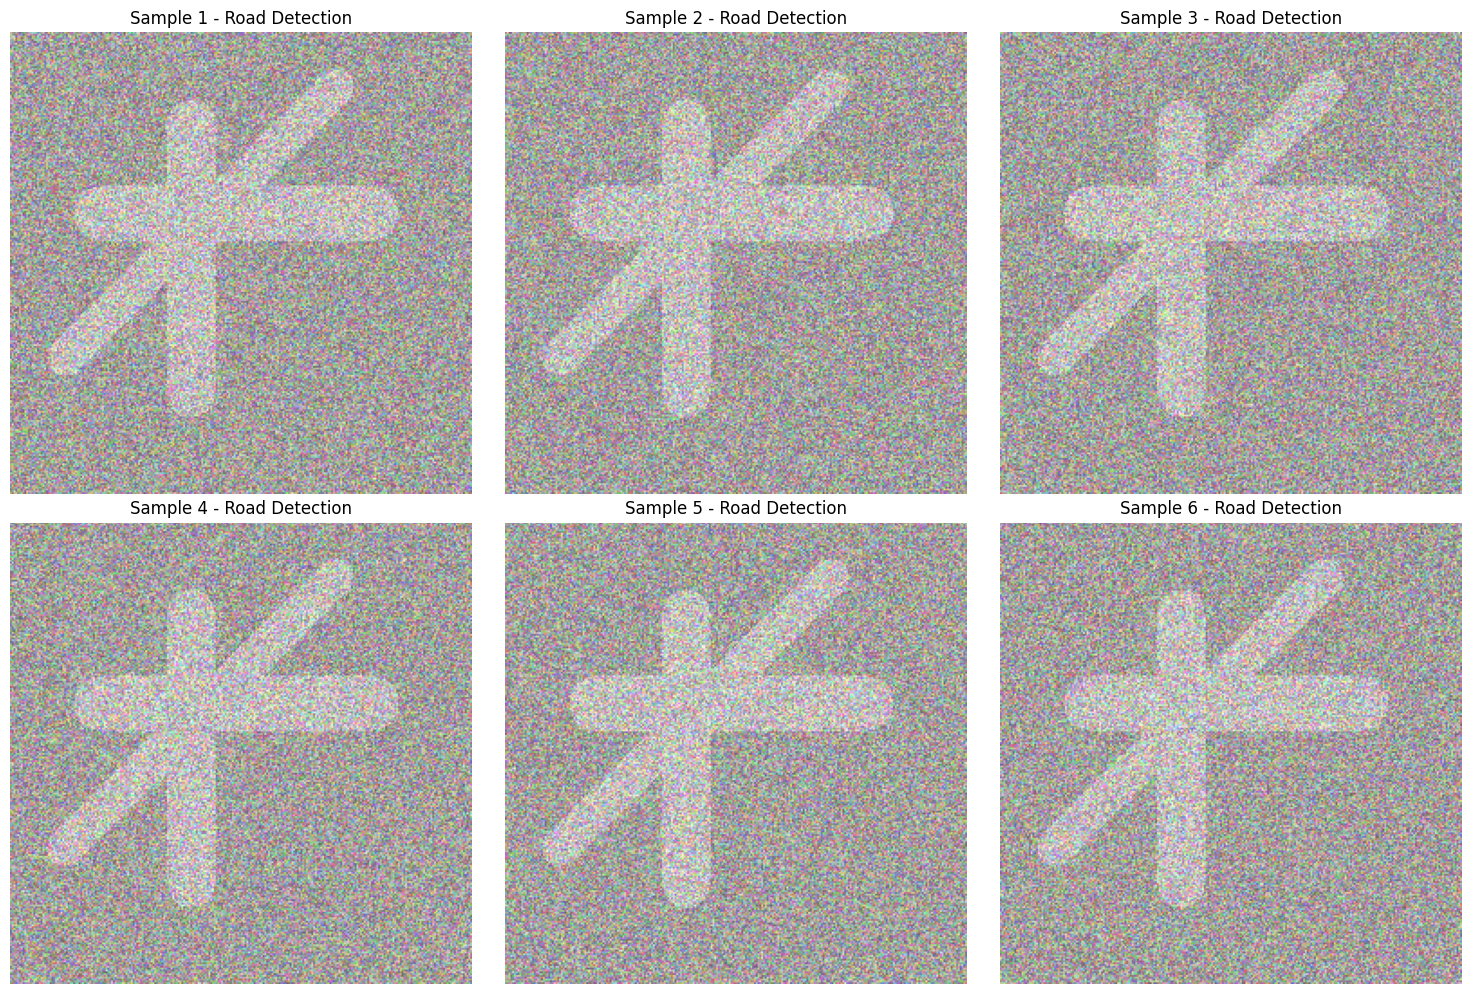

In [29]:
# Step 14: Quick Demo with Multiple Samples
print("Final Demo - Multiple Predictions:")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

model.eval()
with torch.no_grad():
    for i in range(2):
        sample_images, sample_masks = next(iter(val_loader))
        sample_images = sample_images.float().to(device)

        for j in range(3):
            idx = i * 3 + j
            if idx < sample_images.size(0):
                output = model(sample_images[idx:idx+1])
                image_np = sample_images[idx].cpu().permute(1, 2, 0).numpy()
                pred_np = (output[0, 0].cpu().numpy() > 0.5).astype(np.float32)

                axes[i, j].imshow(image_np)
                axes[i, j].imshow(pred_np, alpha=0.4, cmap='Reds')
                axes[i, j].set_title(f'Sample {idx+1} - Road Detection')
                axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [30]:
# 1. Post-processing (clean up predictions)
import cv2
def clean_prediction(mask):
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove noise
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)  # Fill gaps
    return cleaned

# 2. Convert to vector format (for GIS/maps)
def mask_to_polygons(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours  # Now you have road polygons!

# 3. Use pre-trained backbone (better performance)
model = smp.Unet('resnet34', encoder_weights='imagenet', classes=1)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]